# Vehicle Detection Project

The goals / steps of this project are the following:

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Imports

In [11]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
import time

from scipy.ndimage.measurements import label

from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn import discriminant_analysis
from sklearn import ensemble
from sklearn import gaussian_process 
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import neural_network
from sklearn import svm
from sklearn import tree
from sklearn import neural_network

from IPython.display import HTML
from moviepy.editor import VideoFileClip
from tqdm import tqdm


### Settings

In [12]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = 32
hist_bins = 32

conv= cv2.COLOR_RGB2YCrCb
invconv = cv2.COLOR_YCR_CB2RGB

hist_bin_range = (0, 255)

# max 5068
training_size = 5068

figure_size = (16, 16)

feature_scaler = None
feature_scaler_file = 'feature_scaler.pickle'

X_train_npy = 'X_train.npy'
X_test_npy = 'X_test.npy'
y_train_npy = 'y_train.npy'
y_test_npy = 'y_test.npy'

### Functions

In [75]:
def add_heat(heatmap, bbox_list, threshold):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    heatmap[heatmap <= threshold] = 0
    
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec, channel):
    return hog(img[:,:,channel], orientations=orient, 
               pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block), 
               transform_sqrt=False, 
               visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')

def bin_spatial(img, size, channel):
    return cv2.resize(img[:,:,channel], size).ravel()
                        
def color_hist(img, nbins, bins_range, channel):    
    # Compute the histogram of the color channels separately
    channel_hist = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
    return channel_hist[0]

def get_red_features(img, size):
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    
    img = cv2.resize(img, size)
    
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]

    img_bg = cv2.add(img_b, img_g)

    mask = ((img_r > 0) & (img_r > img_bg)).astype(np.uint8) * 255

    img_masked = cv2.bitwise_and(img, img, mask=mask)
    return img_masked.ravel()

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(ctrans_tosearch, scale, clf_list, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    result=[]
    
    #print('ctrans_tosearch.shape =', ctrans_tosearch.shape)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    #print('nxblocks =', nxblocks)
    #print('nyblocks =', nyblocks)
    #print('nfeat_per_block =', nfeat_per_block)

    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    #print('nblocks_per_window =', nblocks_per_window)
    #print('nxsteps =', nxsteps)
    #print('nysteps =', nysteps)

    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, channel=0)
    hog2 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, channel=1)
    hog3 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False, channel=2)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            red_features = get_red_features(subimg, size=(spatial_size, spatial_size))
            
            spatial_features_c0 = bin_spatial(subimg, size=(spatial_size, spatial_size), channel=0)
            spatial_features_c1 = bin_spatial(subimg, size=(spatial_size, spatial_size), channel=1)
            spatial_features_c2 = bin_spatial(subimg, size=(spatial_size, spatial_size), channel=2)
            
            spatial_features = np.hstack([spatial_features_c0, spatial_features_c1, spatial_features_c2])
                        
            hist_features_c0 = color_hist(subimg, nbins=hist_bins, bins_range=hist_bin_range, channel=0)
            hist_features_c1 = color_hist(subimg, nbins=hist_bins, bins_range=hist_bin_range, channel=1)
            hist_features_c2 = color_hist(subimg, nbins=hist_bins, bins_range=hist_bin_range, channel=2)

            hist_features = np.hstack([hist_features_c0, hist_features_c1, hist_features_c2])
                        
            all_features = np.hstack([
                red_features, 
                hog_features, 
                spatial_features, 
                hist_features
            ])
                        
            # Scale features and make a prediction
            test_features = X_scaler.transform(all_features.reshape(1, -1))
            
            test_prediction = 0
            for clf_name in clf_list:
                clf = clf_list[clf_name]
                test_prediction = test_prediction + clf.predict(test_features)

            # If multiple classifiers think it's a car...
            if test_prediction == len(clf_list):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # then it's a car
                result.append([(xbox_left, ytop_draw),(xbox_left+win_draw,ytop_draw+win_draw)]) 
                
    return result

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, ystart, color, thick):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1] + ystart), (bbox[1][0], bbox[1][1] + ystart), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels, ystart, color, thick):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy) + ystart), (np.max(nonzerox), np.max(nonzeroy) + ystart))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1] , color, thick)
    # Return the image
    return img

def process_image(img, conv, clf_list, feature_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    ystart = int(img.shape[0] / 2) + 50
    
    img_search = np.copy(img[ystart : img.shape[0] - 50,])    
    img_search = cv2.cvtColor(img_search, conv)
    
    windows = []
    for scale in np.arange(0.5, 3, 0.5):
        windows.extend(find_cars(img_search, scale, clf_list, feature_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    heat = np.zeros_like(img_search[:,:,0]).astype(np.float)
    heat = add_heat(heat,windows,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)

    img_labeled = draw_labeled_bboxes(np.copy(img), labels, ystart, (0,255,0), 3)

    # PIP
    heatmap = (heatmap * (255 / np.max(heatmap))).astype('uint8')
    heatmap_zeros = np.zeros_like(heatmap)
    heatmap = np.dstack([heatmap, heatmap_zeros, heatmap_zeros])
    heatmap = cv2.resize(heatmap, (int(heatmap.shape[1] / 2), int(heatmap.shape[0] / 2)))
    
    img_labeled[10:heatmap.shape[0] + 10, 10:heatmap.shape[1] + 10] = heatmap
    
    return img_labeled, img, windows, ystart

### Initialization

In [14]:
car_images = []
non_car_images = []

print('Reading', training_size, 'random car images...')
car_image_paths = glob.glob('training_images/cars/*.png')
np.random.shuffle(car_image_paths)
for car_image_path in tqdm(car_image_paths[:training_size]):
    img = mpimg.imread(car_image_path, format='PNG')#.astype(np.float32)/255
    img = cv2.cvtColor(img, conv)
    car_images.append(img)

print('Reading', training_size, 'random non-car images...')
non_car_image_paths = glob.glob('training_images/non_cars/*.png')
np.random.shuffle(non_car_image_paths)
for non_car_image_path in tqdm(non_car_image_paths[:training_size]):
    img = mpimg.imread(non_car_image_path, format='PNG')#.astype(np.float32)/255
    img = cv2.cvtColor(img, conv)
    non_car_images.append(img)

assert len(car_images) == training_size
assert len(non_car_images) == training_size

Reading 5068 random car images...


100%|██████████████████████████████████████████████████████████████████████████████| 5068/5068 [01:12<00:00, 69.68it/s]


Reading 5068 random non-car images...


100%|██████████████████████████████████████████████████████████████████████████████| 5068/5068 [01:08<00:00, 73.45it/s]


### Feature Extractions

###### Red Features

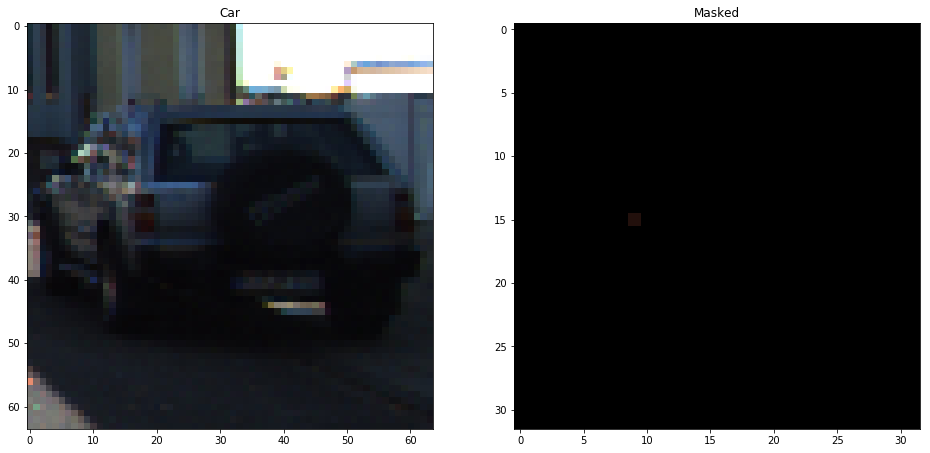

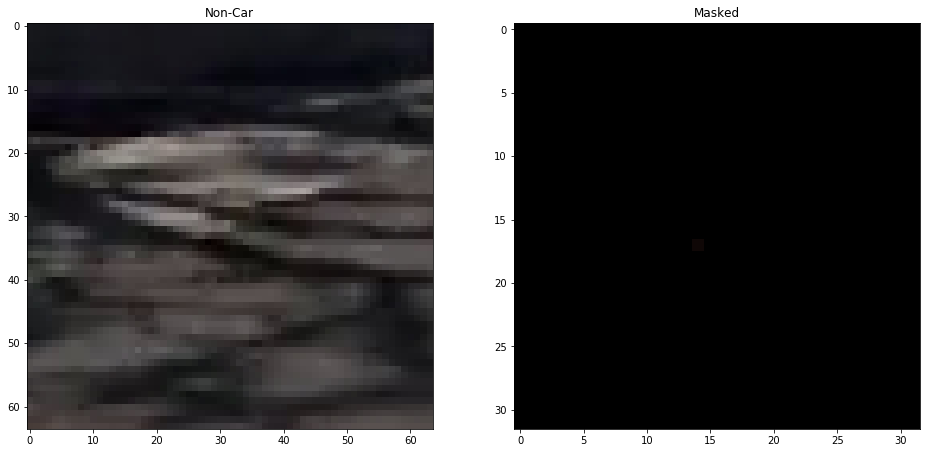

In [15]:
car_red_features_list = []
non_car_red_features_list = []

def show_example(title, img, res):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figure_size)
    ax1.set_title(title)
    ax1.imshow(img)
    
    ax2.set_title('Masked')
    ax2.imshow(res)

for img in car_images:
    features = get_red_features(img, size=(spatial_size, spatial_size))
    car_red_features_list.append(features)

show_example('Car', cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB), features.reshape((spatial_size, spatial_size, 3)))
    
for img in non_car_images:
    features = get_red_features(img, size=(spatial_size, spatial_size))
    non_car_red_features_list.append(features)

show_example('Non-Car', cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB), features.reshape((spatial_size, spatial_size, 3)))


##### Histogram of Oriented Gradients (HOG) feature extraction

Getting HOG features for each car image...


100%|█████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:27<00:00, 182.13it/s]


Getting HOG features for each non-car image...


100%|█████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:26<00:00, 189.78it/s]


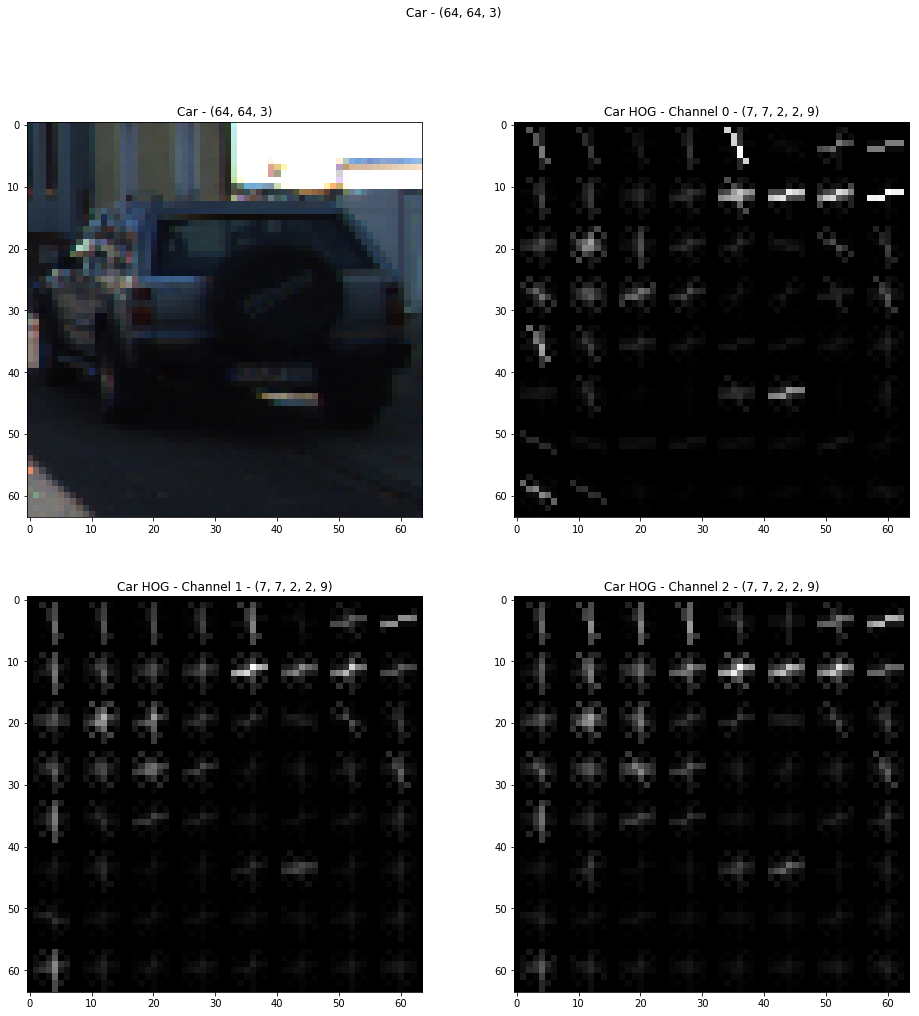

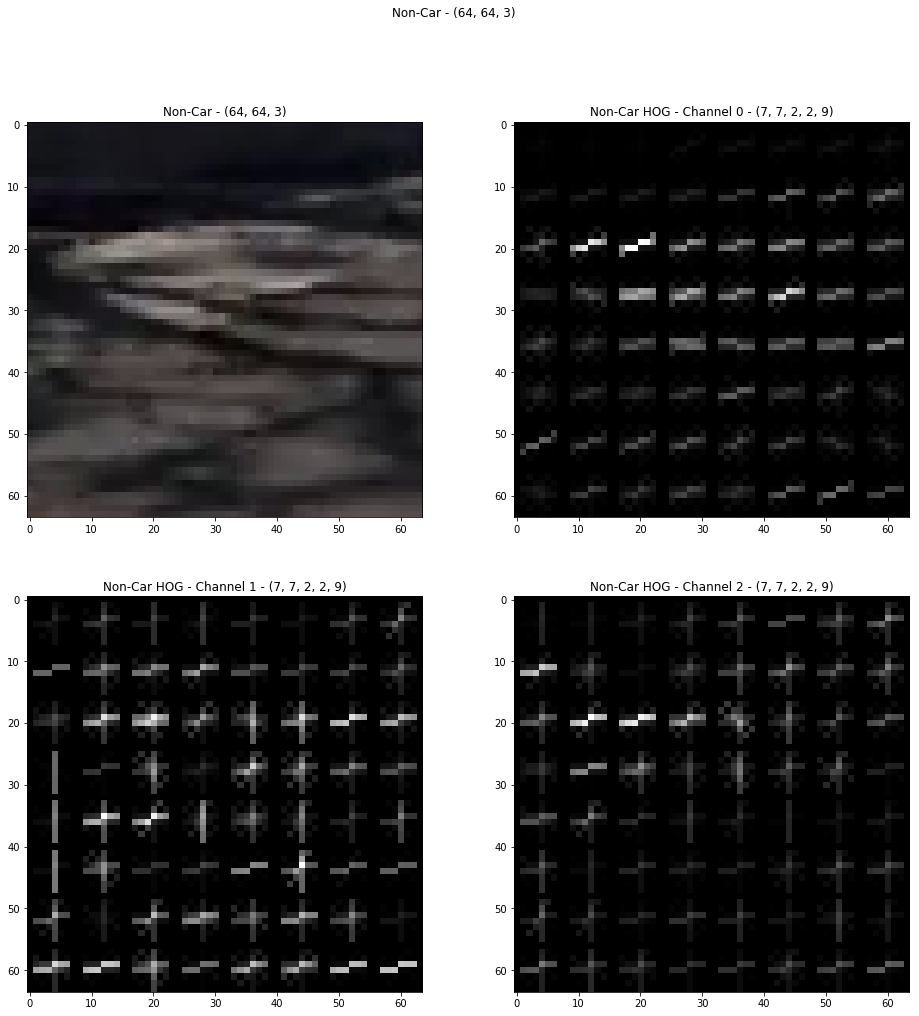

In [16]:
car_hog_features_list = []
non_car_hog_features_list = []

def show_example(title, img):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figure_size)
    f.suptitle('{} - {}'.format(title, img.shape))
    
    ax1.set_title('{} - {}'.format(title, img.shape))
    
    img_rgb = cv2.cvtColor(img, invconv)
    img_rgb[img_rgb < 0] = 0
    ax1.imshow(img_rgb)

    features, img_c0 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False, channel=0)
    ax2.set_title('{} HOG - Channel 0 - {}'.format(title, features.shape))
    ax2.imshow(img_c0, cmap='gray')

    features, img_c1 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False, channel=1)
    ax3.set_title('{} HOG - Channel 1 - {}'.format(title, features.shape))
    ax3.imshow(img_c1, cmap='gray')

    features, img_c2 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False, channel=2)
    ax4.set_title('{} HOG - Channel 2 - {}'.format(title, features.shape))
    ax4.imshow(img_c2, cmap='gray')

print('Getting HOG features for each car image...')
for img in tqdm(car_images):    
    features_c0 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, channel=0)
    features_c1 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, channel=1)
    features_c2 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, channel=2)
    
    features=np.hstack([features_c0, features_c1, features_c2])
    car_hog_features_list.append(features)  

assert len(features.shape) == 1

#Example - Car
show_example('Car', car_images[-1])

print('Getting HOG features for each non-car image...')
for img in tqdm(non_car_images):
    features_c0 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, channel=0)
    features_c1 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, channel=1)
    features_c2 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, channel=2)
    
    features=np.hstack([features_c0, features_c1, features_c2])
    non_car_hog_features_list.append(features)  

assert len(features.shape) == 1

#Example - Non-Car
show_example('Non-Car', non_car_images[-1])



##### Binned color spatial feature extraction

Getting binned spartial features for each car image...


100%|███████████████████████████████████████████████████████████████████████████| 5068/5068 [00:00<00:00, 33902.83it/s]


Getting binned spartial features for each non-car image...


100%|███████████████████████████████████████████████████████████████████████████| 5068/5068 [00:00<00:00, 35768.34it/s]


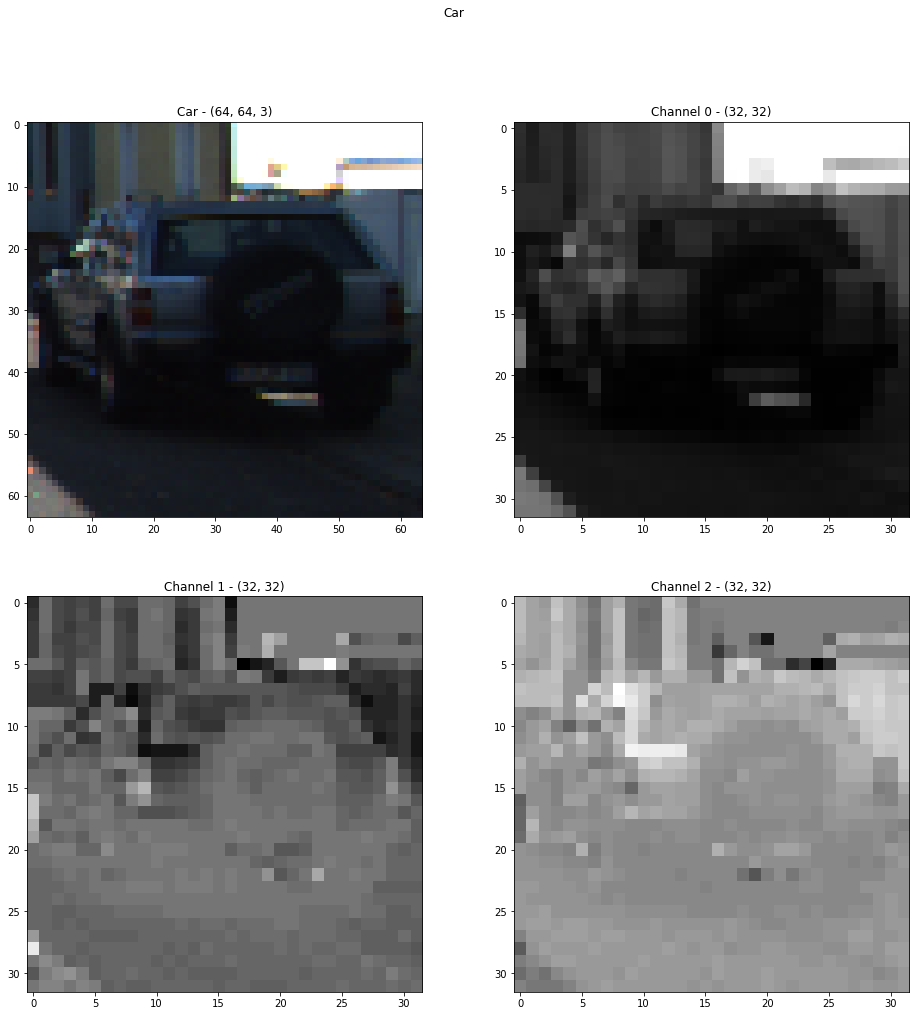

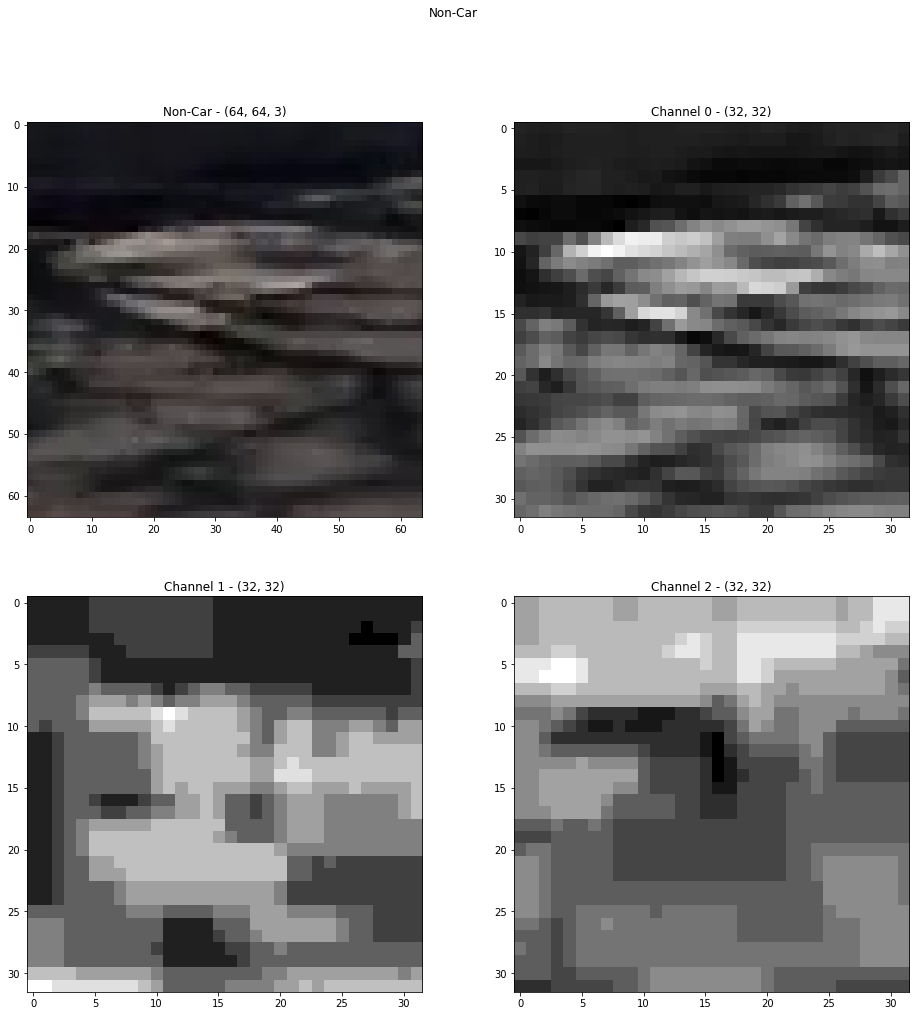

In [17]:
car_bin_features_list = []
non_car_bin_features_list = []

def show_example(title, img, features_c0, features_c1, features_c2):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figure_size)
    f.suptitle('{}'.format(title))
    
    ax1.set_title('{} - {}'.format(title, img.shape))
    img_rgb = cv2.cvtColor(img, invconv)
    img_rgb[img_rgb < 0] = 0
    ax1.imshow(img_rgb)
    
    img_c0 = features_c0.reshape((spatial_size, spatial_size))
    ax2.set_title('Channel 0 - {}'.format(img_c0.shape))
    ax2.imshow(img_c0, cmap='gray')

    img_c1 = features_c1.reshape((spatial_size, spatial_size))
    ax3.set_title('Channel 1 - {}'.format(img_c1.shape))
    ax3.imshow(img_c1, cmap='gray')

    img_c2 = features_c2.reshape((spatial_size, spatial_size))
    ax4.set_title('Channel 2 - {}'.format(img_c2.shape))
    ax4.imshow(img_c2, cmap='gray')


print('Getting binned spartial features for each car image...')
for img in tqdm(car_images): 
    features_c0 = bin_spatial(img, size=(spatial_size, spatial_size), channel=0)
    features_c1 = bin_spatial(img, size=(spatial_size, spatial_size), channel=1)
    features_c2 = bin_spatial(img, size=(spatial_size, spatial_size), channel=2)
    features = np.hstack([features_c0, features_c1, features_c2])
    car_bin_features_list.append(features)

assert len(features.shape) == 1

#Example - Car
show_example('Car', car_images[-1], features_c0, features_c1, features_c2)

print('Getting binned spartial features for each non-car image...')
for img in tqdm(non_car_images): 
    features_c0 = bin_spatial(img, size=(spatial_size, spatial_size), channel=0)
    features_c1 = bin_spatial(img, size=(spatial_size, spatial_size), channel=1)
    features_c2 = bin_spatial(img, size=(spatial_size, spatial_size), channel=2)   
    features = np.hstack([features_c0, features_c1, features_c2])
    non_car_bin_features_list.append(features)

assert len(features.shape) == 1

#Example - Non-Car
show_example('Non-Car', non_car_images[-1], features_c0, features_c1, features_c2)

assert len(car_hog_features_list) == len(car_bin_features_list)
assert len(non_car_hog_features_list) == len(non_car_hog_features_list)

##### Color histogram feature extraction

Getting color histogram features for each car image...


100%|████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:02<00:00, 1946.23it/s]


Getting color histogram features for each non-car image...


100%|████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:02<00:00, 2030.75it/s]


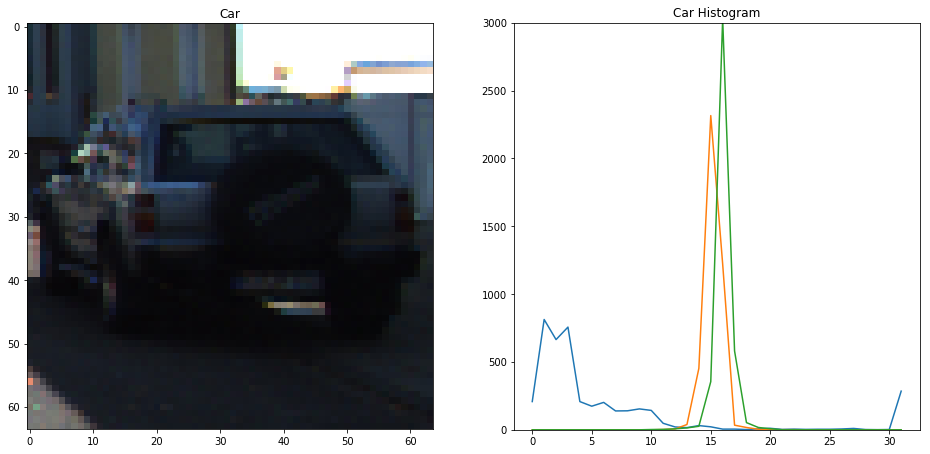

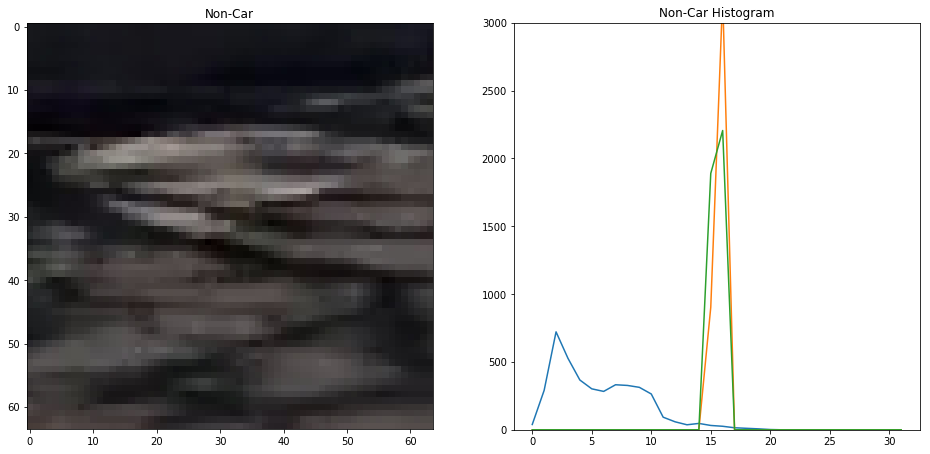

In [18]:
car_hist_features_list = []
non_car_hist_features_list = []

def show_example(title, img, features):
    f = plt.figure(figsize=figure_size)        
    f.add_subplot(1,2,1)
    plt.title(title)
    img_rgb = cv2.cvtColor(img, invconv)
    img_rgb[img_rgb < 0] = 0
    plt.imshow(img_rgb)

    ax = f.add_subplot(1,2,2)
    plt.title('{} Histogram'.format(title))
    ax.set_aspect(.0114)
    plt.plot(features.reshape((-1, hist_bins)).T)
    ax.set_ylim((0, 3000))

print('Getting color histogram features for each car image...')
for img in tqdm(car_images):
    features_c0 = color_hist(img, hist_bins, bins_range=hist_bin_range, channel=0)
    features_c1 = color_hist(img, hist_bins, bins_range=hist_bin_range, channel=1)
    features_c2 = color_hist(img, hist_bins, bins_range=hist_bin_range, channel=2)
    features = np.hstack([features_c0, features_c1, features_c2])

    car_hist_features_list.append(features)

assert len(features.shape) == 1

#Example - Car
show_example('Car', car_images[-1], features)

print('Getting color histogram features for each non-car image...')
for img in tqdm(non_car_images):
    features_c0 = color_hist(img, hist_bins, bins_range=hist_bin_range, channel=0)
    features_c1 = color_hist(img, hist_bins, bins_range=hist_bin_range, channel=1)
    features_c2 = color_hist(img, hist_bins, bins_range=hist_bin_range, channel=2)
    features = np.hstack([features_c0, features_c1, features_c2])
    non_car_hist_features_list.append(features)

assert len(features.shape) == 1

#Example - Non-Car
show_example('Non-Car', non_car_images[-1], features)

assert len(car_bin_features_list) == len(car_hist_features_list)
assert len(non_car_hog_features_list) == len(non_car_hist_features_list)

##### Combine and Normalize

100%|███████████████████████████████████████████████████████████████████████████| 5068/5068 [00:00<00:00, 21145.76it/s]


feature_list.shape = (10136, 11532)


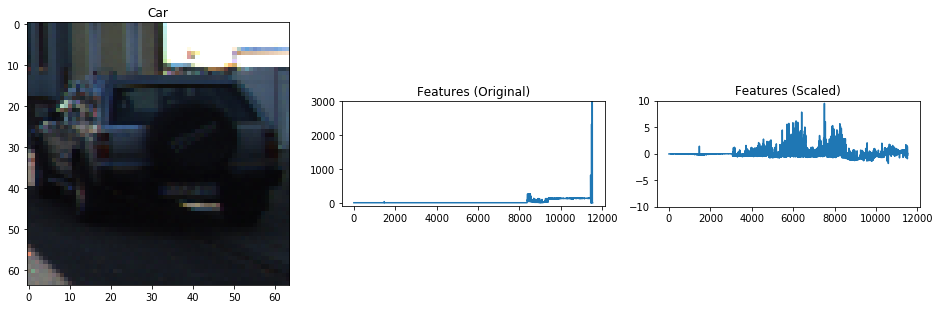

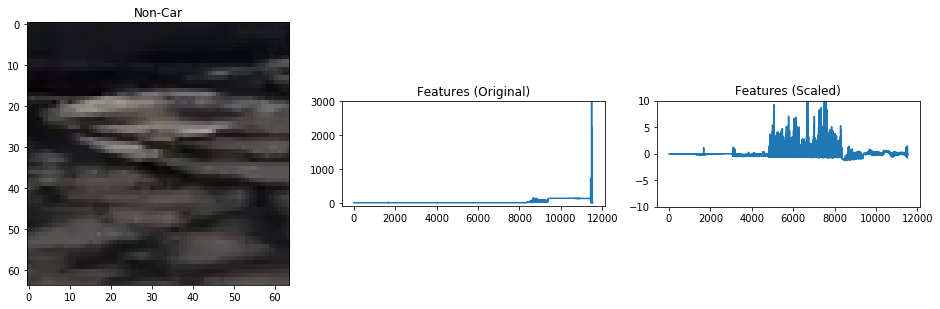

In [19]:
car_features_list = []
non_car_features_list = []

def show_example(title, img, features, scaled_features):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figure_size)
    
    ax1.set_title(title)
    img_rgb = cv2.cvtColor(img, invconv)
    img_rgb[img_rgb < 0] = 0
    ax1.imshow(img_rgb)

    ax2.set_title('Features (Original)'.format(title))
    ax2.set_aspect(1.64)
    ax2.plot(features)
    ax2.set_ylim((-100,3000))

    ax3.set_title('Features (Scaled)'.format(title))
    ax3.set_aspect(256)
    ax3.plot(scaled_features)
    ax3.set_ylim((-10,10))
    

for i in tqdm(range(len(car_images))):
    car_features_list.append(np.hstack([
        car_red_features_list[i],
        car_hog_features_list[i], 
        car_bin_features_list[i], 
        car_hist_features_list[i]
    ]))

assert len(car_features_list[-1].shape) == 1
    
for i in tqdm(range(len(non_car_images))):
    non_car_features_list.append(np.hstack([
        non_car_red_features_list[i],
        non_car_hog_features_list[i], 
        non_car_bin_features_list[i], 
        non_car_hist_features_list[i]
    ]))
    
assert len(non_car_features_list[-1].shape) == 1

features_list = np.vstack([car_features_list, non_car_features_list])

assert features_list.shape[0] == (training_size * 2)

print('feature_list.shape = {}'.format(features_list.shape))

feature_scaler = StandardScaler().fit(features_list)
pickle.dump(feature_scaler, open(feature_scaler_file, 'wb'))

scaled_features_list = feature_scaler.transform(features_list)

labels_list = np.hstack([np.ones(len(car_features_list)), np.zeros(len(non_car_features_list))])

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features_list, labels_list, test_size=0.2, random_state=rand_state)

np.save(X_train_npy, X_train)
np.save(X_test_npy, X_test)
np.save(y_train_npy, y_train)
np.save(y_test_npy, y_test)

assert (len(X_train) + len(X_test)) == len(features_list)
assert (len(y_train) + len(y_test)) == len(features_list)

#show example of scaled features
show_example('Car', car_images[-1], features_list[training_size - 1], scaled_features_list[training_size - 1])
show_example('Non-Car', non_car_images[-1], features_list[-1], scaled_features_list[-1])


### Construct and train the classifier

In [73]:
#parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 3, 6, 9]}
#svc = svm.SVC()
#clf = GridSearchCV(svc, parameters, n_jobs=4, verbose=3)
#clf.fit(X_train, y_train)

#accuracy = clf.score(X_test, y_test)
#params = clf.best_params_
#print('Accuracy = {}, Best Parameters = {}'.format(accuracy, params))

# Best Parameters = {'C': 9, 'kernel': 'rbf'}

#clf = svm.SVC(C=9, kernel='rbf')
#clf = svm.LinearSVC()
#clf = tree.DecisionTreeClassifier()
#clf = naive_bayes.GaussianNB()


if os.path.isfile(X_train_npy):
    X_train = np.load(X_train_npy)

if os.path.isfile(y_train_npy):
    y_train = np.load(y_train_npy)

if os.path.isfile(X_test_npy):
    X_test = np.load(X_test_npy)

if os.path.isfile(y_test_npy):
    y_test = np.load(y_test_npy)


clf_list = {
    'LinearSVC': svm.LinearSVC(C=0.025),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(max_depth=5),
    ##'RandomForestClassifier': ensemble.RandomForestClassifier(max_depth=5),
    ##'MLPClassifier': neural_network.MLPClassifier(),
    ##'AdaBoostClassifier': ensemble.AdaBoostClassifier(),
    'SGDClassifier': linear_model.SGDClassifier()
}

for clf_name in clf_list:
    print('Training {}...'.format(clf_name))

    clf_file = '{}.pickle'.format(clf_name)
    if os.path.isfile(clf_file):
        print('{} found. Loading clf from it...'.format(clf_file))
        clf_list[clf_name] = pickle.load(open(clf_file, 'rb'))
    else:
        clf = clf_list[clf_name]
    
        t1=time.time()
        clf.fit(X_train, y_train)
        t2 = time.time()
        print('Traning took {} seconds.'.format(round(t2 - t1, 2)))

        pickle.dump(clf, open(clf_file, 'wb'))

for clf_name in clf_list:
    clf = clf_list[clf_name]
    
    print('Testing {}...'.format(clf_name))
    t1=time.time()
    accuracy = clf.score(X_test, y_test)
    t2 = time.time()
    print('Testing took {} seconds. Accuracy = {}.'.format(round(t2 - t1, 2), accuracy))


Training LinearSVC...
LinearSVC.pickle found. Loading clf from it...
Training DecisionTreeClassifier...
DecisionTreeClassifier.pickle found. Loading clf from it...
Training SGDClassifier...
SGDClassifier.pickle found. Loading clf from it...
Testing LinearSVC...
Testing took 0.06 seconds. Accuracy = 0.9995069033530573.
Testing DecisionTreeClassifier...
Testing took 0.08 seconds. Accuracy = 0.9980276134122288.
Testing SGDClassifier...
Testing took 0.05 seconds. Accuracy = 0.9995069033530573.


### Image Test

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  2.19s/it]


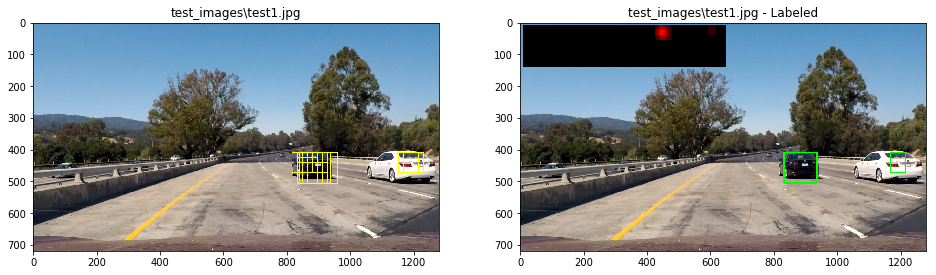

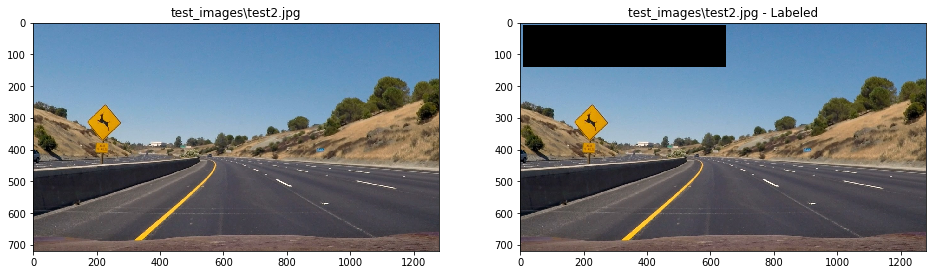

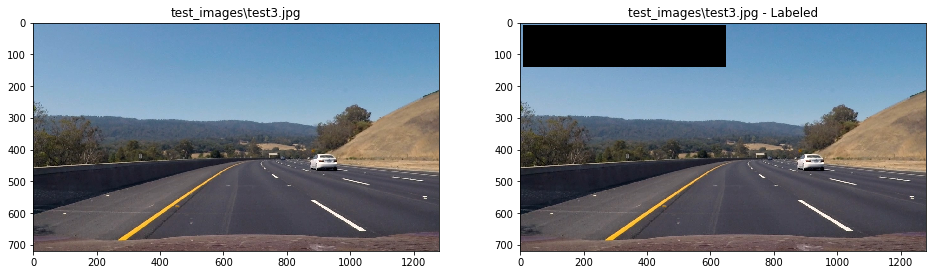

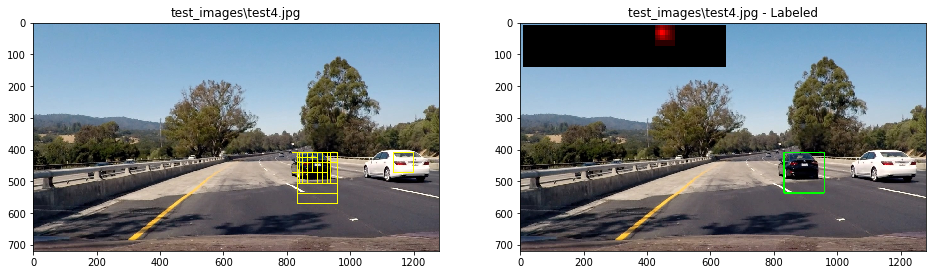

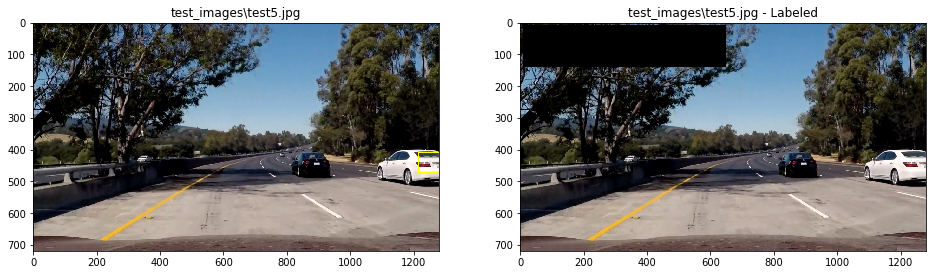

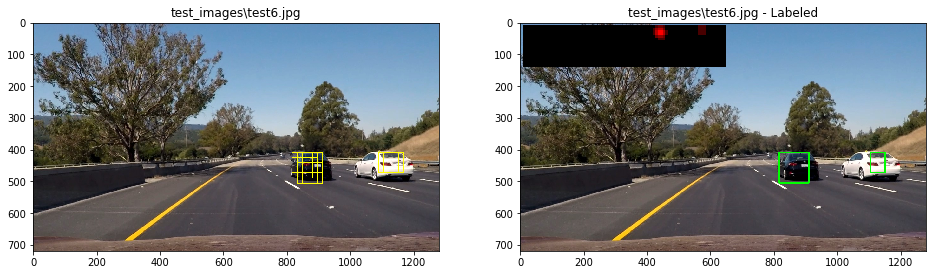

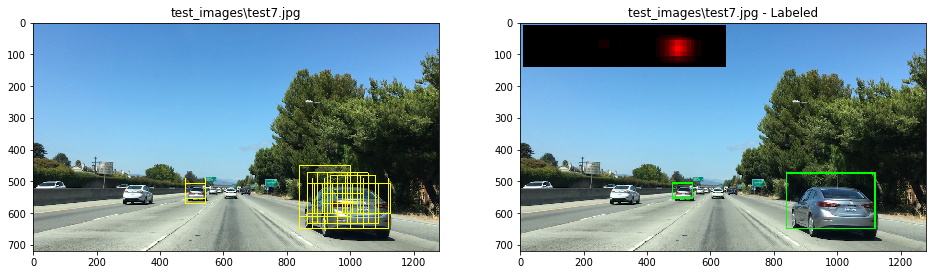

In [77]:
test_image_hog_list = []

def show_example(img_rgb, img_labeled, windows, ystart):
    f = plt.figure(figsize=figure_size)        

    img_boxes = draw_boxes(np.copy(img_rgb), windows, ystart, (255,255,0), 2)

    f.add_subplot(1,2,1)
    plt.title(test_image_path)
    plt.imshow(img_boxes)
    
    f.add_subplot(1,2,2)
    plt.title('{} - Labeled'.format(test_image_path))
    plt.imshow(img_labeled)
    

#print('svc =', clf)
#print('X_scaler =', feature_scaler)
#print('orient =', orient)
#print('pix_per_cell =', pix_per_cell)
#print('cell_per_block =', cell_per_block)
#print('spatial_size =', spatial_size)
#print('hist_bins =', hist_bins)

if feature_scaler is None and os.path.isfile(feature_scaler_file):
    feature_scaler = pickle.load(open(feature_scaler_file, 'rb'))

test_image_paths = glob.glob('test_images/*.jpg')
for test_image_path in tqdm(test_image_paths):
    img = mpimg.imread(test_image_path, format='JPG')#.astype(np.float32)/255

    img_labeled, img_rgb, windows, ystart = process_image(img, conv, clf_list, feature_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
    show_example(img_rgb, img_labeled, windows, ystart)

### Video Test

In [ ]:
  
output_video_path = 'test_video_output.mp4'
output_video = VideoFileClip("test_video.mp4").fl_image(lambda img: process_image(img, conv, scale, clf_list, feature_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)[0])